##TOBDA Functions Notebook
This notebook contains each function and example for converting to a Bird Eye View that plays the main role of the TOBDA app.


> *   Depth Estimation
*   Semantic Segmentation
* Real World Mapping From Depth Map
* Select points from image
* Bird Eye View Transform





## Load libraries and Dataset

In [ ]:
!git clone https://github.com/taegukang35/device_for_blind

fatal: destination path 'device_for_blind' already exists and is not an empty directory.


In [ ]:
import json
import urllib.request
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
base_dir = '/content'
images_dir = os.path.join(base_dir,'datasets')
os.mkdir(images_dir)


def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

#https://segments.ai/prgmti1/school_hallway_v2/releases 에서 받은 v.01 json 파일 
with open('/content/device_for_blind/school_hallway_ver2-v0.1','r') as f:
  dataset = json.load(f) 

for i in range(400):
    img_url = dataset['dataset']['samples'][i]['attributes']['image']['url']
    img_name = dataset['dataset']['samples'][i]['name']
    img = url_to_image(img_url)
    cv2.imwrite(os.path.join(images_dir,img_name),img)

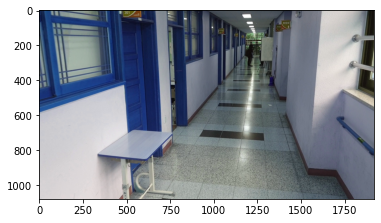

In [ ]:
img_path = "/content/datasets/412.jpg"
img = cv2.imread(img_path) 
img = cv2.resize(img, dsize=(1920,1080), interpolation=cv2.INTER_AREA)
plt.imshow(img)

## Depth Estimation
Depth Estimation was carried out using MiDas, a model learned from datasets targeting indoor spaces.
- video: https://www.youtube.com/watch?v=p8Vm0s8-S_Y&ab_channel=TaeguKang

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    #tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(gpu,
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
# load model
module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# https://tfhub.dev/intel/midas/v2/2
def predict_depth(img):
    # input
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
    img_resized = tf.transpose(img_resized, [2, 0, 1])
    img_input = img_resized.numpy()
    reshape_img = img_input.reshape(1,3,256,256)
    tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

    output = module.signatures['serving_default'](tensor)
    prediction = output['default'].numpy()
    prediction = prediction.reshape(256, 256)
                
    # output 
    prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    return prediction

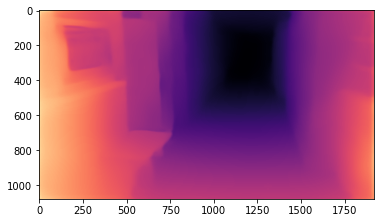

In [ ]:
depth_map = predict_depth(img) 
plt.imshow(depth_map,cmap='magma')

## Semantic Segmentation
We made a dataset from the hallway of Gyeonggibuk Science High School and trained U-net for Semantic Segmentation. 
- Dataset: https://www.kaggle.com/taegukang0305/semantic-hallway-dataset 
- Unet Notebook: https://github.com/taegukang35/device_for_blind/blob/main/hallway_unet_best.ipynb
- Video: https://www.youtube.com/watch?v=ZjD5f1sja1A&ab_channel=TaeguKang 

In [ ]:
from keras.models import Model, load_model

In [ ]:
def predict_mask(img):
    # load model
    seg_model = load_model('/content/device_for_blind/model-best-unet.h5')

    # input     
    img_resized = tf.image.resize(img, (256, 256) ,method='bicubic', preserve_aspect_ratio=False)
    img_resized = img_resized.numpy()
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)

    img_input = np.expand_dims(img_resized,axis=0)
    tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)
    mask = seg_model.predict(tensor)

    # Image Thresholding
    threshold = 0.8
    _, mask = cv2.threshold(mask[0][...,0], threshold * mask[0][...,0].max(), 1, cv2.THRESH_BINARY)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    #plt.imshow(mask)
    return mask

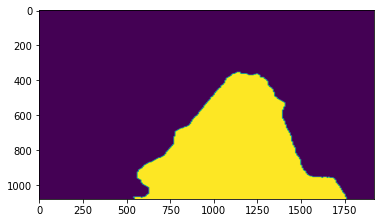

In [ ]:
mask = predict_mask(img)
plt.imshow(mask)

## Real World Mapping From Depth Map
We matched a image pixel (u,v,d) to a point cloud (x,y,z) of the real world based on camera's properties and geometric relationships. 
- More information: https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f 

In [ ]:
class Projection:
    def __init__(self, cx, cy, fx, fy, pxToMetre):
        self.cx = cx
        self.cy = cy
        self.fx = fx
        self.fy = fy
        self.pxToMetre = pxToMetre

    def convert_from_uvd(self, u, v, d):
        d *= self.pxToMetre
        x_over_z = (self.cx - u) / self.fx
        y_over_z = (self.cy - v) / self.fy
        z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
        x = x_over_z * z
        y = y_over_z * z
        return int(x),int(y),int(z)
    
    def match_point(self,u,v,depth:np.ndarray):
        x,y,z = self.convert_from_uvd(u,v,depth.max()-depth[u][v])
        return x,y,z

    def run(self, seg: np.ndarray, depth: np.ndarray):
        points = []
        for i in range(int(2*self.cx)):
            for j in range(int(2*self.cy)):
                if seg[i][j] ==1:
                    points.append((self.convert_from_uvd(i,j,depth[i][j])))
        return points

## Select points from image
In order to find the transformation matrix, you need to know the correspondence of four points. If you just choose randomly, it will be difficult to find a suitable transformation matrix.

In [ ]:
def find_points(mask:np.ndarray): 
    # find mask's biggest contour
    thresholded_mask = cv2.convertScaleAbs(mask)
    contours, _ = cv2.findContours(thresholded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_areas = []   
    for i, c in enumerate(contours):
        contour_areas.append(cv2.contourArea(c))
    sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)
    biggest_contour= sorted_contours[0][1]
    contour_image = cv2.drawContours(np.array(img), biggest_contour, -1, (255, 255, 255), 3)
    x,y,w,h = cv2.boundingRect(biggest_contour)

    # four suitable points
    points = []
    left = True
    for i in range(0,img.shape[1]):
        if mask[y+50][i]==1 and left==True:
            points.append((y+100,i+20))
            left = False
        if mask[y+50][i]==0 and left==False:
            points.append((y+100,i-20))
            break
    points.append((y+h-50,x+100))
    points.append((y+h-50,x+w-100))
    return points

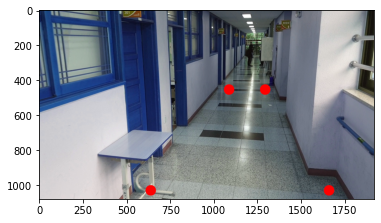

In [ ]:
test_img = cv2.imread(img_path)
test_img = cv2.resize(test_img, dsize=(1920,1080), interpolation=cv2.INTER_AREA)
points = find_points(mask=mask)
for point in points:
    cv2.circle(test_img, (point[1], point[0]), 30, (255, 0 ,0), -1)
plt.imshow(test_img)

## Bird Eye View Transform
This is a process of integrating the above steps to obtain a transformation matrix and converting it into Bird eye view.

In [ ]:
def warpBird(image:np.ndarray,mask:np.ndarray,depth:np.ndarray,points:list): 
    # find matrix for warping transform
    P = Projection(img.shape[0]/2,img.shape[1]/2,1000,1000,1)
    pts1,pts2 = [],[]
    for point in points:
        pts1.append((point[1],point[0]))
    for point in points:
        x,y,z= P.match_point(point[0],point[1],depth=depth)
        pts2.append((1100-y,2500-z))
    pts1,pts2 = np.float32(pts1),np.float32(pts2)
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    #print(matrix.shape)

    # warping transform
    warped_img = cv2.warpPerspective(img,matrix,(2000,2000))
    warped_mask = cv2.warpPerspective(mask,matrix,(2000,2000))
    return warped_img,warped_mask

In [ ]:
warped_img,warped_mask = warpBird(img,mask=mask,depth=depth_map,points=points)

(3, 3)


(-0.5, 1999.5, 1999.5, -0.5)

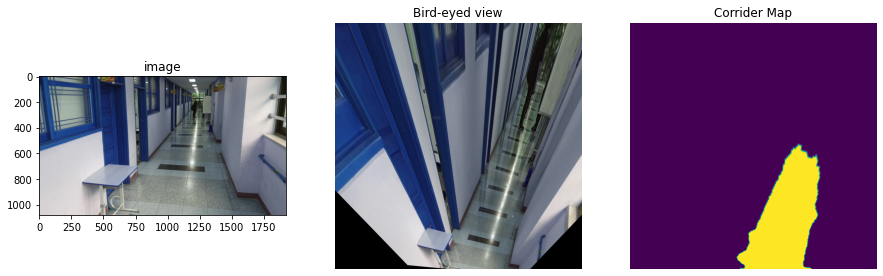

In [ ]:
# plot result
fig = plt.figure(figsize=(15,10))     
rows = 1
cols = 3
ax0 = fig.add_subplot(rows, cols, 1)
ax0.set_title('image')
ax0.imshow(img)
ax1 = fig.add_subplot(rows, cols, 2)
ax1.imshow(warped_img)
ax1.set_title('Bird-eyed view')
ax1.axis("off")
ax2 = fig.add_subplot(rows, cols, 3)
ax2.imshow(warped_mask)
ax2.set_title('Corrider Map')
ax2.axis("off")

#Make Video

In [ ]:
SAVE_PATH = os.path.join(base_dir,'birdeye')
#os.mkdir(SAVE_PATH)
images_dir = "/content/datasets"
for i in range(400):
    img_path = os.path.join(images_dir,'{0}.jpg'.format(i))
    if os.path.isfile(img_path):
        img = cv2.imread(img_path) 
        img = cv2.resize(img, dsize=(1920,1080), interpolation=cv2.INTER_AREA)
        depth_map = predict_depth(img) 
        mask = predict_mask(img)
        warped_img,warped_mask = warpBird(img,mask=mask,depth=depth_map,points=points)
        # plot result
        fig = plt.figure(figsize=(15,10))     
        rows = 1
        cols = 3
        ax0 = fig.add_subplot(rows, cols, 1)
        ax0.set_title('image')
        ax0.imshow(img)
        ax1 = fig.add_subplot(rows, cols, 2)
        ax1.imshow(warped_img)
        ax1.set_title('Bird eye view')
        ax1.axis("off")
        ax2 = fig.add_subplot(rows, cols, 3)
        ax2.imshow(warped_mask)
        ax2.set_title('Corrider Map')
        ax2.axis("off")
        plt.savefig(os.path.join(SAVE_PATH,'{0}.png'.format(i)))

video = []
for i in range(400):
    img_path = os.path.join(SAVE_PATH,'{0}.png'.format(i))
    if os.path.isfile(img_path):
        img = cv2.imread(img_path)
        video.append(img)

h,w,l = video[0].shape
size = (w,h)
out = cv2.VideoWriter('birdeyes_video.avi',cv2.VideoWriter_fourcc(*'DIVX'),10, size)
 
for i in range(len(video)):
    out.write(video[i])
out.release()